# [ICM Development](@id Development)

The model from Saiz et al has three parts in the model

## Definition of the model

### Mechanics

The cells are spheroids that behave under the following equations:

$$m_i\frac{dv_i}{dt} =-bv_i+\sum_j F_{ij}$$

$$\frac{dx_i}{dt} =v_i$$

where the force is

$$F_{ij}=
\begin{cases}
F_0(\frac{r_{ij}}{d_{ij}}-1)(\frac{\mu r_{ij}}{d_{ij}}-1)\frac{(x_i-x_j)}{d_{ij}}\hspace{1cm}if\;d_{ij}<\mu r_{ij}\\
0\hspace{5cm}otherwise
\end{cases}$$

where $d_{ij}$ is the Euclidean distance and $r_{ij}$ is the sum of both radius.

### Biochemical interaction

Each cell has a biochemical component that follows an equation of the form:

$$\frac{dx_i}{dt}=\frac{α(1+x^n_i)^m}{(1+x^n_i)^m+(1+(\langle x\rangle_i)/K)^{2m}}-x_i$$

This is similar to the above case. The only detail required is to note that the average expression can be modeled as the combination of two interacting variables. The biochemical system is activated in the interval $[t_{on},t_{off}]$.

We made explicit that the average operator can be written as two interaction parameters that are the contraction along the second index that runs over the neighbours of each cell as,

$$N_{ij}=
\begin{cases}
1\hspace{1cm}d<f_{range}r_{ij}\\
0\hspace{1cm}otherwise
\end{cases}$$

$$X_{ij}=
\begin{cases}
x_j\hspace{1cm}d<f_{range}r_{ij}\\
0\hspace{1cm}otherwise
\end{cases}$$

$$\langle x\rangle_i=\frac{\sum_j X_{ij}}{\sum_j N_{ij}}=\frac{X_{i}}{N_{i}}$$

### Growth

The cells present division. The rules for the division in this model are. Random election of a division direction over the unit sphere. The daughter cells divide equally in mass and volume and are positioned in oposite directions around the division axis centered at the parent cell. The chemical concentration is divided asymmetrically with each cell taking $1\pm\sigma_x \text{Uniform}(0,1)$ for the parent cell. A new division time is assigned to each aghter cell from a uniform distribution $\text{Uniform}(\tau_{div}(1-\sigma_{div}),\tau_{div}(1+\sigma_{div}))$.

## Creation of the Agent

In [1]:
#Package
using AgentBasedModels
#Functions for generating random distributions
using Random
using Distributions
#Package for plotting in 3D
using GLMakie
GLMakie.inline!(true)

### Define the agent

First, we have to create an instance of an agent with all the propoerties of the agents.First, we have to create an instance of an agent with all the propoerties of the agents.

In [2]:
model = Agent(3,

    #Inherit model mechanics
    baseModelInit = [Models.softSpheres3D],

    #Global parameters
    globalFloat = [
        #Chemical constants
        :α, :K, :nn, :mm,
        #Physical constants
        :fRange, :mi, :ri, :k0,
        #Division constants
        :fAdh, :τDiv, :σDiv, :c0, :σc, :nCirc, :σNCirc,
        :fMin, :fMax, :fPrE, :fEPI, :τCirc, :στCirc, :rESC,
        :nOn, :cMax
    ],
    #Local float parameters
    localFloat = [
        :c,
        :tDivision #Variable storing the time of division of the cell
    ],
    #Local interactions
    localFloatInteraction = [
        :ci, #Chemical activity of the neighbors
        :ni  #Number of neighbors
    ],
    #Local integer parameters
    localInt = [
        :tOff,    #indicate if the circuit for that cell is on or off (0,1)
        :cellFate #Identity of the cell (1 DP, 2 EPI, 3 PRE)
    ],
    #Chemical dynamics
    updateVariable = quote
        act = 0.
        if tOff == 0 && N > nOn #Activate circuit
            act = 1.
        else
            act = 0.
        end
        d( c ) = dt( act * ( α*(1+c^nn)^mm/((1+c^nn)^mm+(1+(ci/(ni+1))/K)^(2*mm))-c ) )
    end,
    #Interaction computation
    updateInteraction= quote
        dij = euclideanDistance(x.i,x.j,y.i,y.j,z.i,z.j)
        if dij < fRange*rij #Unnecessary to compute dij and rij again, previously computed in UpdateInteraction
            ni.i += 1
            ci.i += c.j
        end 
    end,
    updateLocal=quote
        #Circuit deactivation and comitment
        if c < fPrE*cMax && tOff == 0 && N > nOn
            cellFate = 3
            tOff = 1
        elseif c > fEPI*cMax && tOff == 0 && N > nOn
            cellFate = 2
            tOff = 1
        end

        #Growth
        if t > tDivision
            #Choose random direction in unit sphere
            xₐ = Normal(0,1); yₐ = Normal(0,1); zₐ = Normal(0,1)
            Tₐ = sqrt(xₐ^2+yₐ^2+zₐ^2)
            xₐ /= Tₐ;yₐ /= Tₐ;zₐ /= Tₐ    

            #Chose a random distribution of the material
            dist = Uniform(1-σc,1+σc)

            rsep = r/2
            rnew = r/(2. ^(1. /3))
            
            addAgent( #Add new agent
                x = x+rsep*xₐ,
                y = y+rsep*yₐ,
                z = z+rsep*zₐ,
                vx = 0,
                vy = 0,
                vz = 0,
                r = rnew,
                m = m/2,
                c = c*(dist),
                tDivision = tDivision + Uniform(τDiv*(1-σDiv),τDiv*(1+σDiv))
            )
            addAgent( #Add new agent
                x = x-rsep*xₐ,
                y = y-rsep*yₐ,
                z = z-rsep*zₐ,
                vx = 0,
                vy = 0,
                vz = 0,
                r = rnew,
                m = m/2,
                c = c*(2-dist),
                tDivision = tDivision + Uniform(τDiv*(1-σDiv),τDiv*(1+σDiv))
            )
            removeAgent() # Remove agent that divided
            
        end
    end,

    integrator = :Heun
);

## Community construction and initialisation

Once with the model created, we have to construct an initial Community of agents to evolve.

### Parameters

The model from the original version has some parameters defined. We create a dictionary with all the parameters from the model assigned.

In [3]:
parameters = Dict([
:α => 10,
:K => .9,
:nn => 2,
:mm => 2,
:fRange => 1.2,
:mi => 10E-6,
:ri => 5,
:b => 10E-6,
:k0 => 10E-4,
:fAdh => 1.5,
:μ => 2,
:τDiv => 10,
:σDiv => .5,
:c0 => 3,
:σc => 0.01,
:nCirc => 20,
:σNCirc => .1,
:fMin => .05,
:fMax => .95,
:fPrE => .2,
:fEPI => .8,
:τCirc => 45.,
:στCirc => .02,
:rESC => 2
]);

### Initialise the community

The model starts from just one agent. Create the community and assign all the parameters to the Community object.

In [4]:
function initializeEmbryo(parameters)

    com = Community(model,N=[1])

    #Global parameters
    for (par,val) in pairs(parameters)
        setproperty!(com,par,val)
    end

    com.nOn = rand(Uniform(parameters[:nCirc]-parameters[:σNCirc],parameters[:nCirc]+parameters[:σNCirc]))
    com.cMax = parameters[:α]/(1+1/(2*parameters[:K])^(2*parameters[:mm]))

    #########Local parameters and variables###########
    com.f0 = parameters[:k0]# / parameters[:fAdh]
    #Initialise locals
    com.m = parameters[:mi]
    com.r = parameters[:ri]
    com.cellFate = 1 #Start neutral fate
    com.tOff = 0 #Start with the tOff deactivated
    #Initialise variables
    com.x = 0.
    com.y = 0.
    com.z = 0.
    com.vx = 0.
    com.vy = 0.
    com.vz = 0.
    com.c = com.c0
    com.tDivision = 1#rand(Uniform(com.τDiv-com.σDiv,com.τDiv+com.σDiv))

    return com

end;

In [5]:
com = initializeEmbryo(parameters);

## Creating a custom evolve step

In [6]:
function customEvolve!(com,dt,steps,saveEach)
    com.dt = dt
    loadToPlatform!(com,preallocateAgents = 100)
    for i in 1:steps
        interactionStep!(com)
        integrationStep!(com)
        localStep!(com)
        update!(com)
        computeNeighbors!(com)
        if i % saveEach == 0
            saveRAM!(com)
        end
        #Stop by time
        if all(com.N .> 60)
            break
        end
    end
    bringFromPlatform!(com)
end;

In [36]:
dt = 0.002
steps = round(Int64,50/dt)
saveEach = round(Int64,.5/dt)

com = initializeEmbryo(parameters);
customEvolve!(com,dt,steps,saveEach)

### Visualization of results

We check how the agents starts to divide and choose a fate at late stages of the simulation.

In [38]:
d = getParameter(com,[:x,:y,:z,:r,:cellFate])
colorMap = Dict(1=>:blue,2=>:orange,3=>:green)
for (i,pos) in enumerate(1:length(com))
    color = [colorMap[i] for i in d[:cellFate][pos]]
    fig = Figure(resolution=(2000,2000))
    ax = Axis3(fig[1,1],aspect = :data)
    meshscatter!(ax,d[:x][pos],d[:y][pos],d[:z][pos],markersize=d[:r][pos],color=color)
    xlims!(ax,-7,7)
    ylims!(ax,-7,7)
    zlims!(ax,-7,7)

    ind = "000$i"
    save("video/Development$(ind[end-2:end]).jpeg",fig)
end

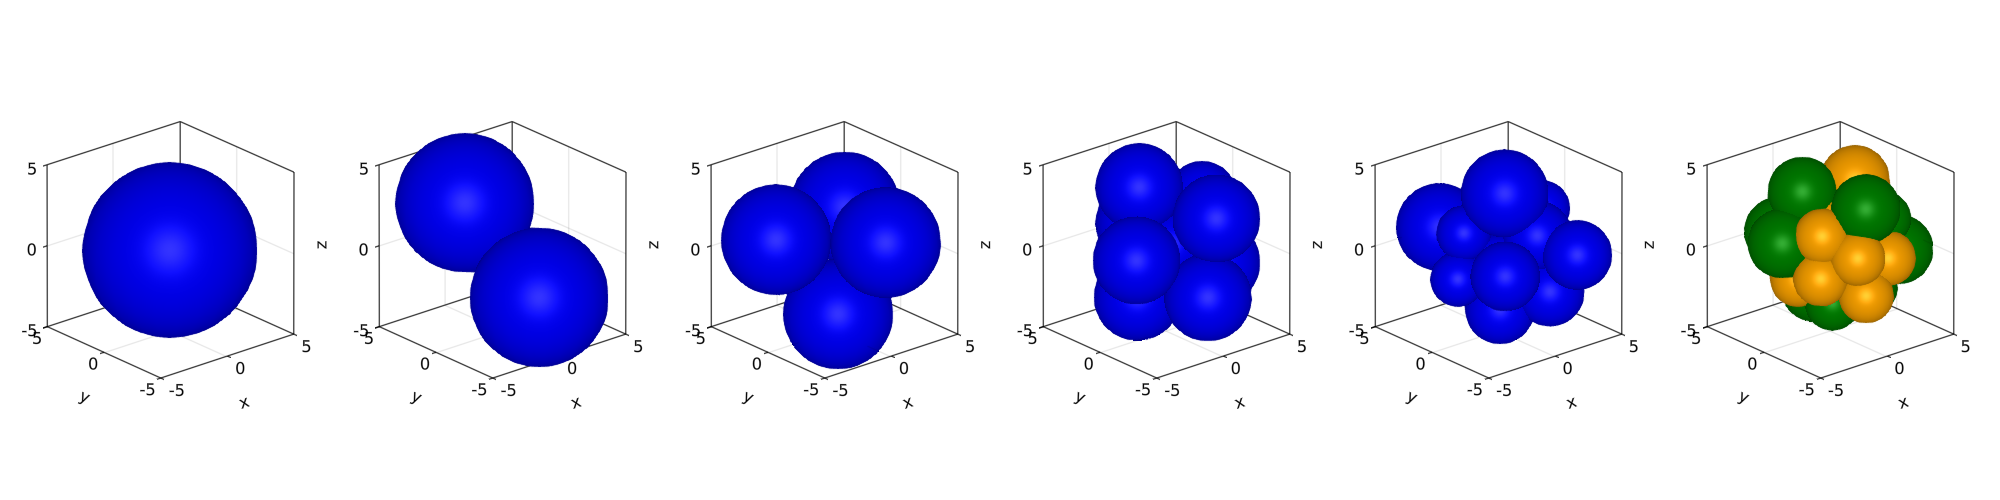

In [37]:
fig = Figure(resolution=(2000,500))

d = getParameter(com,[:x,:y,:z,:r,:cellFate])
colorMap = Dict(1=>:blue,2=>:orange,3=>:green)
for (i,pos) in enumerate([1:10:length(com);length(com)])
    ax = Axis3(fig[1,i],aspect = :data)
    color = [colorMap[i] for i in d[:cellFate][pos]]
    meshscatter!(ax,d[:x][pos],d[:y][pos],d[:z][pos],markersize=d[:r][pos],color=color)
    xlims!(ax,-5,5)
    ylims!(ax,-5,5)
    zlims!(ax,-5,5)
end

fig

In [ ]:
function getProportions(com)
    d = getParameter(com,[:cellFate])

    proportions = []
    for fate in [1,2,3]
        fateList = []
        sizeList = []
        for (i,pos) in enumerate(1:length(com))
            push!( sizeList, length(d[:cellFate][pos]) )
            push!( fateList, sum(d[:cellFate][pos].==fate) )
        end
        prop = fateList./sizeList
        push!(proportions,prop)
    end

    return proportions
end;

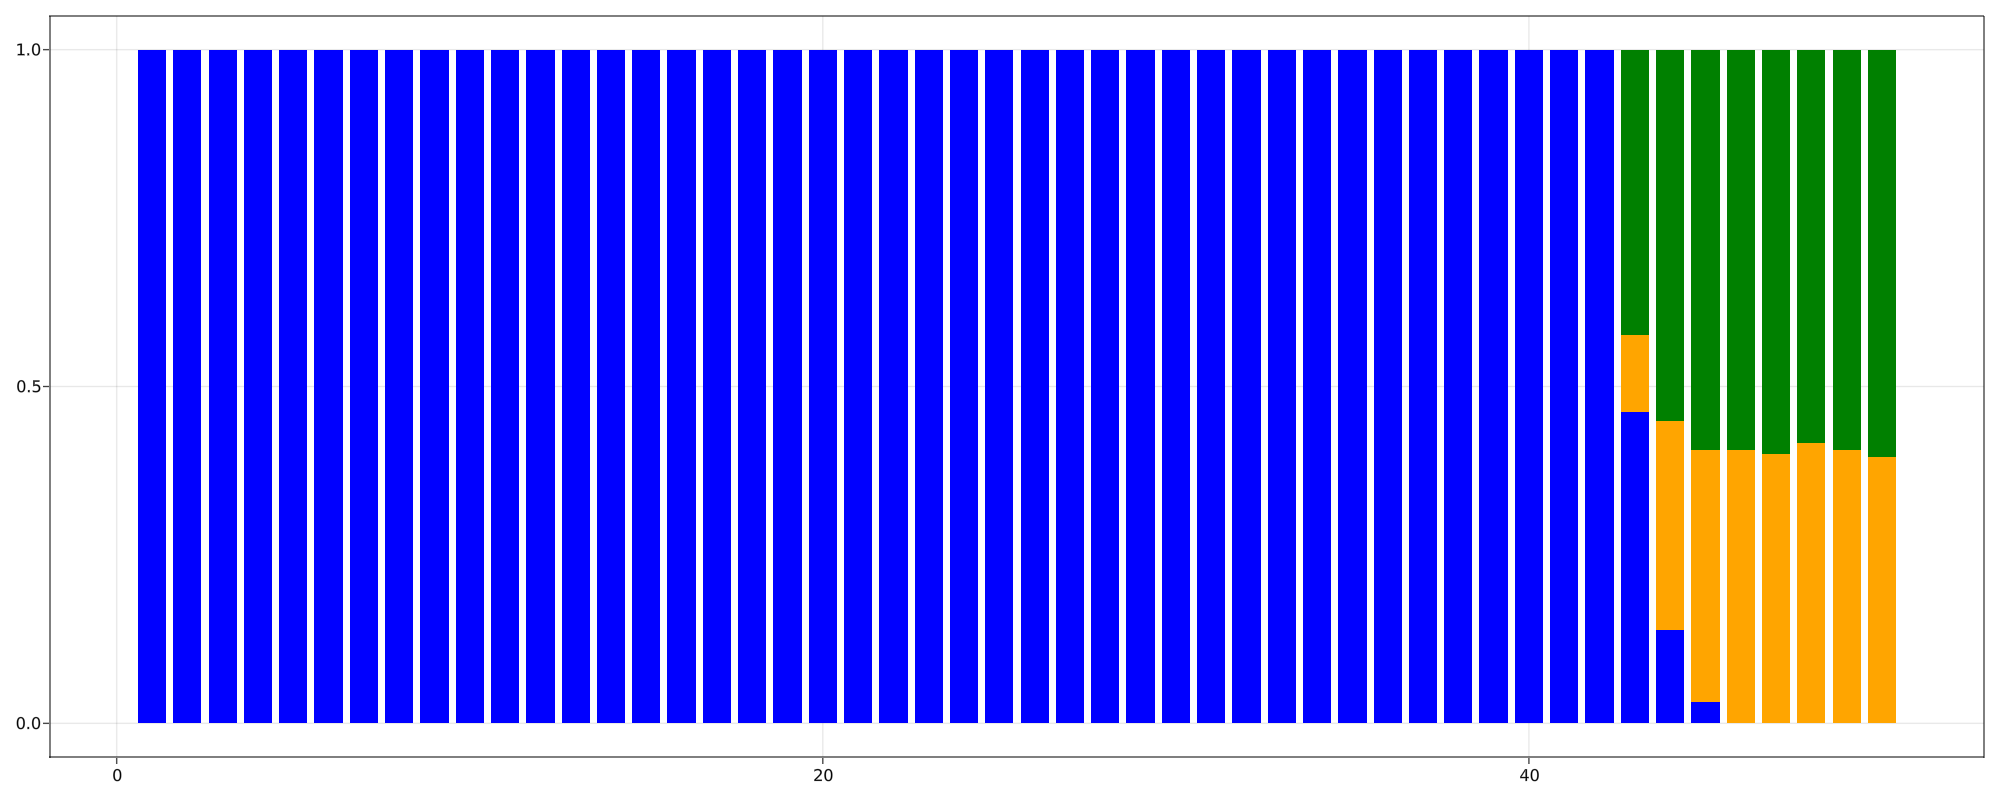

In [57]:
fig = Figure(resolution=(2000,800))

ax = Axis(fig[1,1])

colorMap = Dict(1=>:blue,2=>:orange,3=>:green)
offset = zeros(length(com))
prop = getProportions(com)
for fate in [1,2,3]
    barplot!(ax,1:length(com),prop[fate],offset=offset,color=colorMap[fate])
    offset .+= prop[fate]
end

fig

### Make statistics of the model

This model contains stochasticity in the division times and the concentration of chemical components that the daughter agents receive. This will make different runs of the simulation to differ. In order to make statistics we run the model several times and collect information of the size and fates of the cells.

In [128]:
function makeStatisticsTime(dt,steps,saveEach,nRepetitions)

    #Make simulations and add results to list
    propList = Dict( 1=>[], 2=>[], 3=>[] )
    for i in 1:nRepetitions
        #Make the simulations
        com = initializeEmbryo(parameters);
        customEvolve!(com,dt,steps,saveEach)
    
        #Add them to the model
        prop = getProportions(com)
        for fate in 1:3
            for (j,p) in enumerate(prop[fate])
                if j > length(propList[fate])
                    push!(propList[fate],prop[fate][j:j])
                else
                    push!(propList[fate][j],prop[fate][j])
                end
            end
        end
    end

    #Make statistics of the results
    propMean = deepcopy(propList)
    propStd = deepcopy(propList)
    for fate in 1:3
        for j in 1:length(propList[fate])
            propMean[fate][j] = mean(propList[fate][j])
            propStd[fate][j] = std(propList[fate][j])
        end
    end

    return propMean, propStd
end;

makeStatistics (generic function with 1 method)

In [129]:
dt = 0.0002
steps = round(Int64,50/dt)
saveEach = round(Int64,1/dt)

nRepetitions = 2

propMean, propStd = makeStatistics(dt,steps,saveEach,nRepetitions);

(Dict{Int64, Vector{Any}}(2 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.24, 0.25925925925925924, 0.25925925925925924, 0.25, 0.22972972972972974, 0.2976190476190476, 0.38390243902439025, 0.43863636363636366, 0.4754500818330606, 0.4517945109078114], 3 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.26, 0.24074074074074073, 0.24074074074074073, 0.25, 0.2702702702702703, 0.39285714285714285, 0.47609756097560973, 0.5213636363636364, 0.5053191489361701, 0.513722730471499], 1 => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.5, 0.5, 0.5, 0.5, 0.5, 0.30952380952380953, 0.14, 0.04, 0.019230769230769232, 0.034482758620689655]), Dict{Int64, Vector{Any}}(2 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.33941125496954283, 0.36664796061524685, 0.36664796061524685, 0.3535533905932738, 0.32488689946408944, 0.2862098876231264, 0.14694023843193618, 0.054640069455324125, 0.019674002095206696, 0.053742105818541254], 3 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

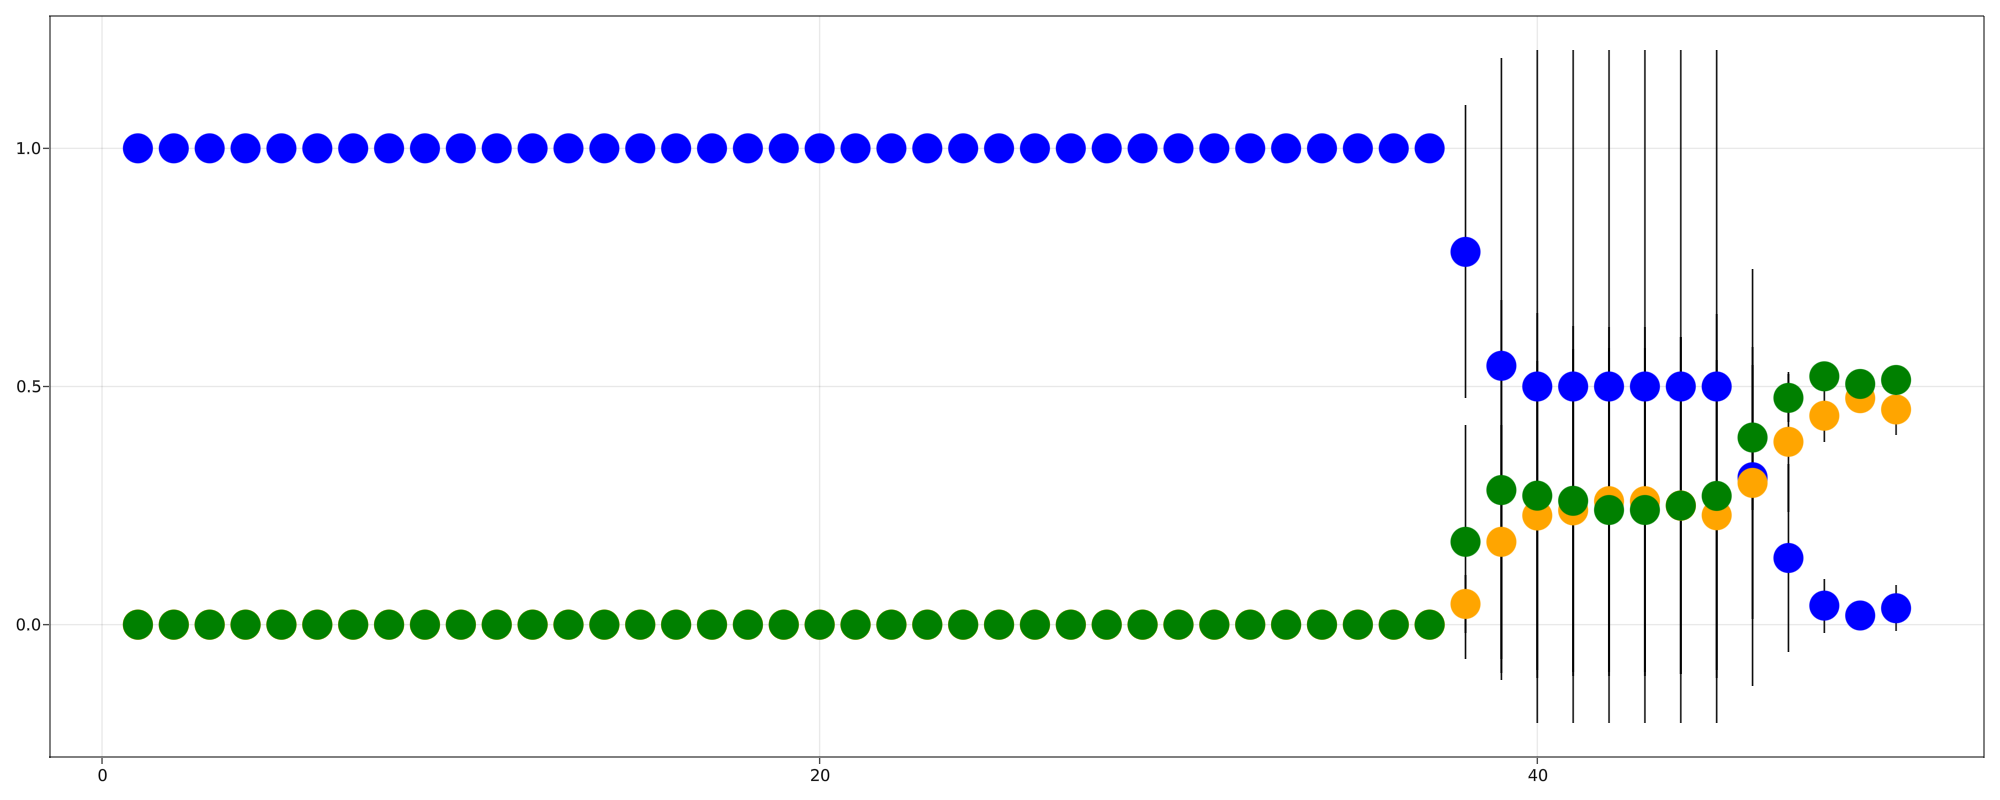

In [130]:
fig = Figure(resolution=(2000,800))

ax = Axis(fig[1,1])
for fate in 1:3
    errorbars!(ax,1:length(propMean[fate]),propMean[fate],propStd[fate],color=:black)
end
for fate in 1:3
    scatter!(ax,1.:length(propMean[fate]),Float64.(propMean[fate]),markersize=30,color=colorMap[fate])
end

fig

## Fitting the model

The parameters above described were chosen to match the experimental observation. This was a qualitative fitting where the parameters where tuned by hand.

In this section we will show how we can use tuning functions to choose optimize certain parameters of the model. In particular, we tune the model to fit parameters related with the chemical circuit to match the correct distributions of cells.

### Upload experimental data

We upload the experimental data that gives raise to this model.

In [11]:
data = CustomFunction.uploadExperimentalData();

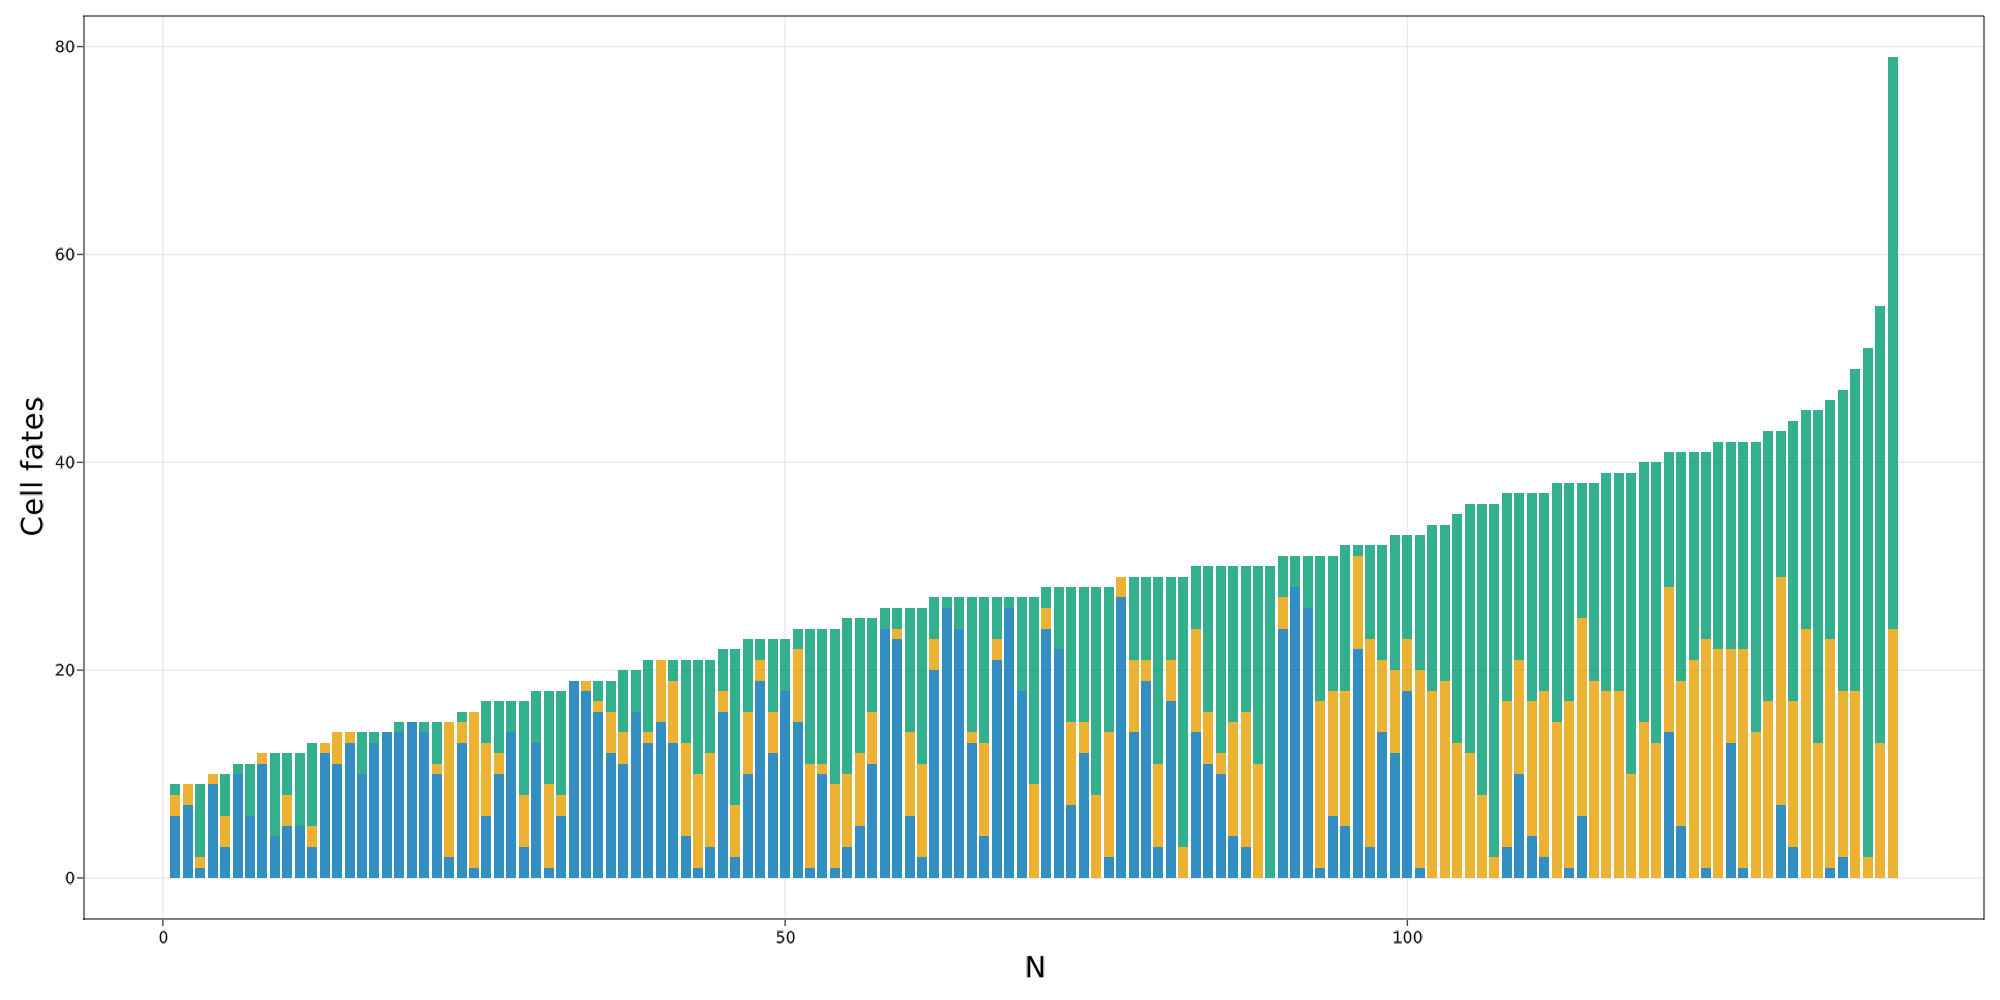

In [12]:
fig = Figure(resolution=(2000,1000))

ax = Axis(fig[1,1],xlabel="N",xlabelsize=30,ylabel="Cell fates",ylabelsize=30)

offset = zeros(size(data)[1])
legend = []
for cellId in ["DP","EPI","PRE"]
    bp = barplot!(ax,data[!,cellId], offset=offset)
    push!(legend,bp)
    offset .+= data[!,cellId]
end

fig

We see that the data corresponds to sets ranging from 5 to 60 cells, being the usual sized between 5 to 30. 

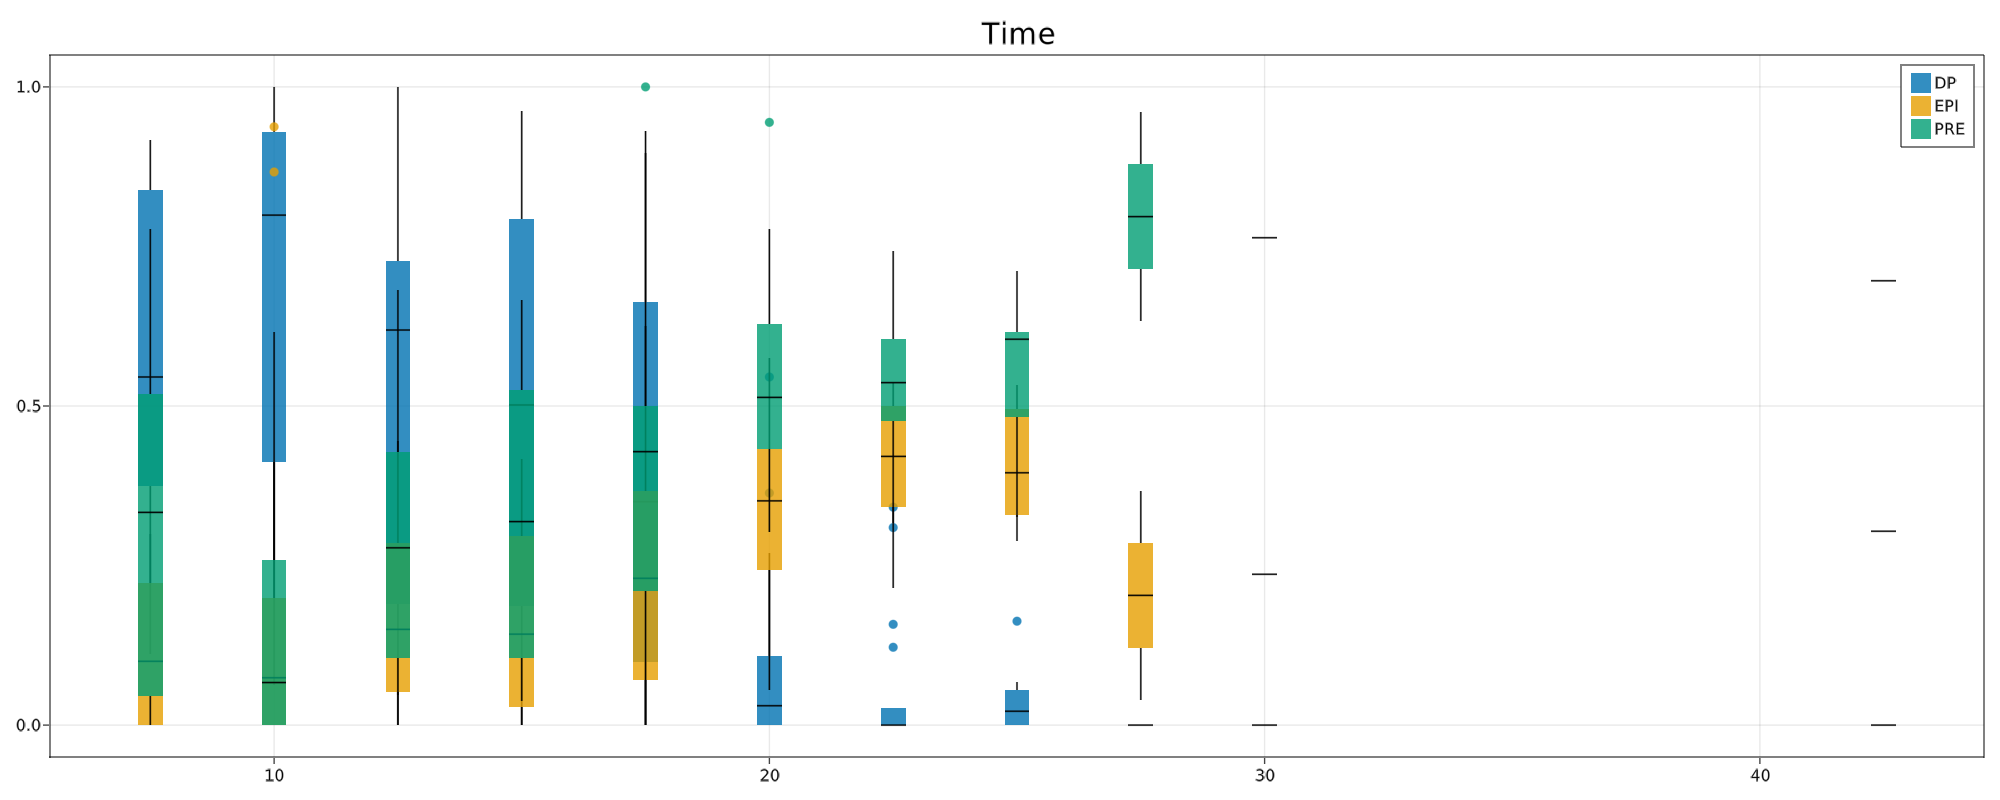

In [13]:
fig = Figure(resolution=(2000,800))

cluster = 5
CustomFunction.plotData(data,cluster,fig,1,1)

fig

### Prepare experimental data for fitting

To increase the statistical power, we cluster the data into bins of total cell number and compute the mean and variance statistics.

In [14]:
dataFit = CustomFunction.clusterExperimentalData(data)

,NCluster,PropDPMean,PropEpiMean,PropPreMean,PropDPVar,PropEpiVar,PropPreVar
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,7.5,0.57213,0.117172,0.310698,0.0783641,0.0129534,0.0826128
2,10.0,0.666324,0.185325,0.148351,0.106707,0.0813161,0.0356754
3,12.5,0.531393,0.190841,0.277767,0.103513,0.0274729,0.0444675
4,15.0,0.508135,0.164428,0.327437,0.111539,0.0209876,0.0471392
5,17.5,0.381015,0.226418,0.392567,0.102499,0.0299968,0.0612153
6,20.0,0.111762,0.346149,0.542089,0.03021,0.0243066,0.0308021
7,22.5,0.0591382,0.411671,0.529191,0.0121628,0.00968479,0.0125616
8,25.0,0.0421807,0.409438,0.548381,0.00349641,0.00972507,0.0162125
9,27.5,0.0,0.203281,0.796719,1.0,0.0538351,0.0538351


### Note on simulated data

We cluster the data in the same way so we can compare the experiments and simulations. Notice that the simulations have statistics at all sizes. We will have to limit to the experimental range in order to compare them.

In [15]:
dataExperimentalFit = CustomFunction.clusterSimulatedData(simulatedData)

,NCluster,PropDPMean,PropEpiMean,PropPreMean,PropDPVar,PropEpiVar,PropPreVar
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.5,1.0,0.0,0.0,0.0,0.0,0.0
2,5.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7.5,1.0,0.0,0.0,0.0,0.0,0.0
4,10.0,1.0,0.0,0.0,0.0,0.0,0.0
5,12.5,0.958042,0.0,0.041958,0.0154833,0.0,0.0154833
6,15.0,0.433957,0.0399762,0.526067,0.125634,0.0037344,0.0999143
7,17.5,0.106723,0.143919,0.749358,0.0264177,0.00596286,0.0117087
8,20.0,0.00958891,0.205069,0.785342,0.000286084,0.00118204,0.000720346
9,22.5,0.00134953,0.200886,0.797764,3.46033e-5,0.00137099,0.00141768


### Set the exploration space

The optimization algorithms require that you specify a set of parameters to optimize. in our case, our parameters correspond to parameters to the agent. However, they does not need to correcpond to parameters of the agent at all. They will be specified for the algorithm to sample from them and give new updates while optimising. 

We have to define them as a dicctionary.

In [16]:
explore = Dict([
            :α=>(0,20),
            :K=>(0,2),
            :nn=>(0,5),
            :mm=>(0,5)
        ]);

### Construct loos function

With the data prepared to be compared, we set the loos function. 

The loos function is a function that has to receive at least one argument, a `RowDataframe` object that contains the information of the parameters that are being fitted and has to return a value indicating how good wwere the simulations.

The function is very general so it can fit a many different routines.

Our function basically contains the following steps:

 - Sets the new parameters
 - Run several simulations for that set of parameters to get robust statistics
 - Cluster the results from the simulations as before to compare it to the experimental data
 - Compare the experimental and simulation results using a Chi Square metric as loos value.
 
The specific form of the function will depend on the optimization algorithm at hand.

In [17]:
function loosFunction(params,parameters,dataFit,nRepetitions=10)

    #Modify the set of parameters
    parametersModified = copy(parameters)
    parametersModified[:α] = params.α[1]
    parametersModified[:K] = params.K[1]
    parametersModified[:nn] = params.nn[1]
    parametersModified[:mm] = params.mm[1]
    
    #Make a batch of simulations and get relevant information
    simulatedData = CustomFunction.batchSimulations(mCompiled, parametersModified, nRepetitions)

    #Prepare data for fitting
    simulatedFit = CustomFunction.clusterSimulatedData(simulatedData,5)[3:2+size(dataFit)[1],:]
    
    #Xi square loos
    loos = sum((simulatedFit.PropDPMean .- dataFit.PropDPMean).^2 ./dataFit.PropDPVar .+
    (simulatedFit.PropEpiMean .- dataFit.PropEpiMean).^2 ./dataFit.PropEpiVar .+
    (simulatedFit.PropPreMean .- dataFit.PropPreMean).^2 ./dataFit.PropPreVar)
    
    #Return loos
    return loos
    
end

loosFunction (generic function with 2 methods)

### Check stability of loos function

We run the loos function several times to check that the results are consistent between runs. If the loos function returned different results outside the expected fluctuations, the model would not be proporly fitted as the algorithms would not be able to minimize consistently the cost.

The fluctuations for the simulations using 10 repetitions of the simulation for the same parameters show already enough consistency.

In [18]:
initialisation = DataFrame([:α=>parameters[:α],:K=>parameters[:K],:nn=>parameters[:nn],:mm=>parameters[:mm]])

Threads.@threads for i in 1:6
    println(loosFunction(initialisation,parameters,dataFit,10))
end

37.524702069795865
35.692004150800024
39.58578228237162
38.01336764695495
36.61591815064281
38.63926523924343


### Run the optimization algorithm

Once we have set the loos function and the parameter space to be explored, we can run the algorithm.

The algorithm has done a good job finding a fet of parameters that fits the data. Moreover, it fits better the data than the qualitative fitting that seems to want ot match only the final proportions at step 30.

The discrepacy at earlier time comes from the fact that the chemical circuit only starts at a critial size of `N=20`. A further improvement on the optimization would be to change this global parameter i the system or even to add it to the fitting process.

Overall, we showed the capacity of AgentBasedModels to fit models to real data.

In [19]:
AgentBasedModels.Optimization.swarmAlgorithm(loosFunction,
                                        explore,
                                        population=50,
                                        stopMaxGenerations=10,
                                        saveFileName="OptimizationResults",
                                        args=[parameters,dataFit,10]
                                    )

Generation 1/10 100%|████████████████████████████████████| Time: 0:04:20
Generation 2/10 100%|████████████████████████████████████| Time: 0:04:19
Generation 3/10 100%|████████████████████████████████████| Time: 0:04:19
Generation 4/10 100%|████████████████████████████████████| Time: 0:04:23
Generation 5/10 100%|████████████████████████████████████| Time: 0:04:16
Generation 6/10 100%|████████████████████████████████████| Time: 0:04:12
Generation 7/10 100%|████████████████████████████████████| Time: 0:04:11
Generation 8/10 100%|████████████████████████████████████| Time: 0:04:12
Generation 9/10 100%|████████████████████████████████████| Time: 0:04:11
Generation 10/10 100%|███████████████████████████████████| Time: 0:04:13


,α,nn,K,mm,α_velocity_,nn_velocity_,K_velocity_,mm_velocity_
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
456,10.0549,1.92812,1.16596,1.85842,0.447707,0.053659,-0.0858023,0.00522784


### Visualize results

Clearly the algorithm tends to converge to better solutions over time.

A plot of the best solution 

In [27]:
optimization = CSV.read("OptimizationResults.csv",DataFrame);

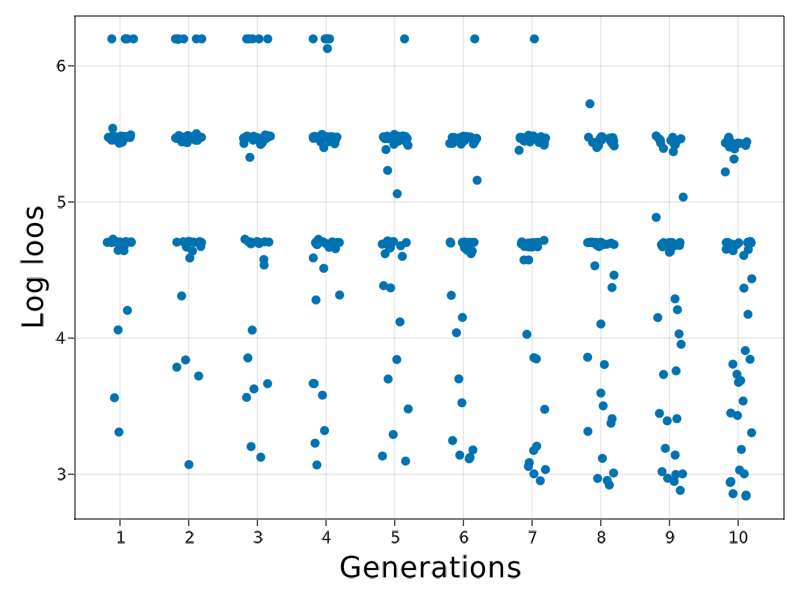

In [76]:
fig = Figure()
ax = Axis(fig[1,1],xticks=1:10,xlabel="Generations",xlabelsize=30,ylabel="Log loos",ylabelsize=30)

scatter!(ax,optimization._generation_.+rand(Uniform(-.2,.2),500),log.(optimization._score_))
#xticks!(ax,[1,2,3],[1,2,3])

fig

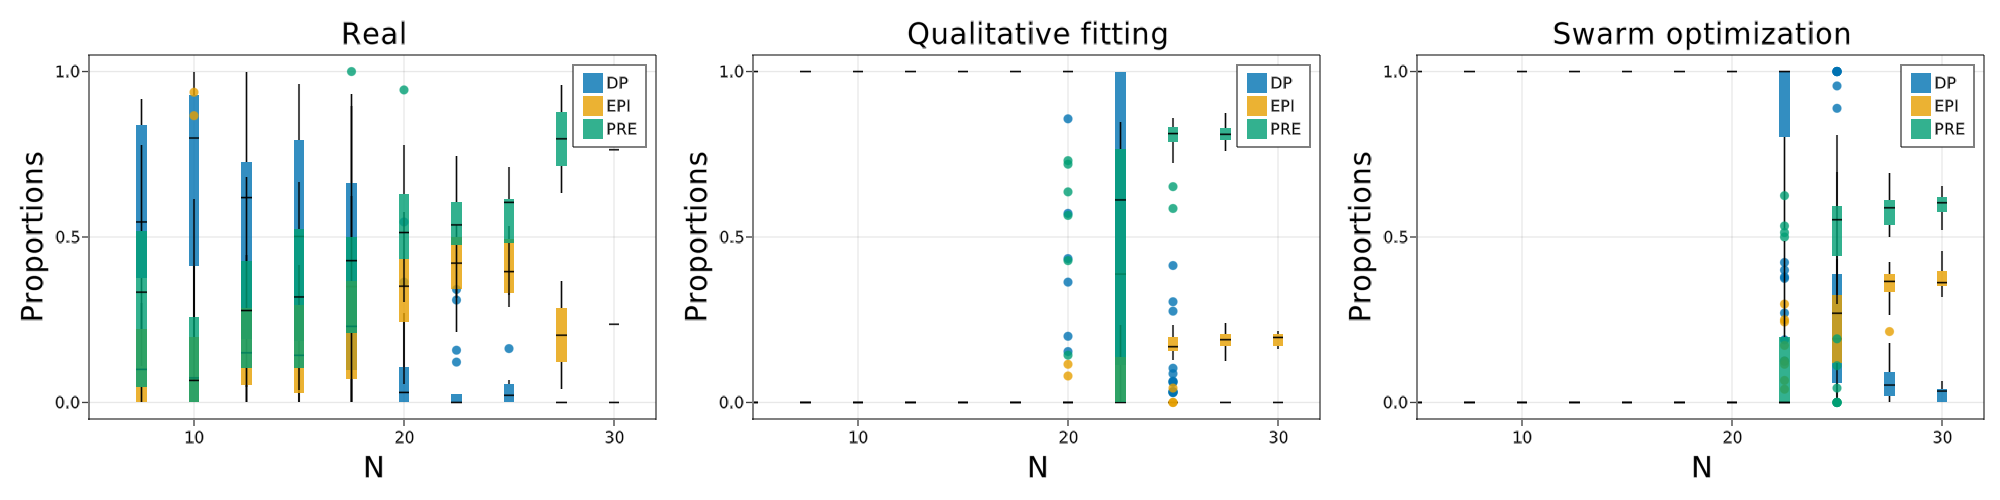

In [107]:
fig = Figure(resolution=(2000,500))

cluster = 5
ax = CustomFunction.plotData(data[1:end,:],cluster,fig,1,1)
ax.title="Real"; ax.titlesize = 30;
ax.xlabel="N"; ax.xlabelsize = 30;
ax.ylabel="Proportions"; ax.ylabelsize = 30;
xlims!(ax,5,32)

cluster = 5
#simulatedData = CustomFunction.batchSimulations(mCompiled, parameters)
ax = CustomFunction.plotProportions(simulatedData,cluster,fig,1,2)
ax.title="Qualitative fitting"; ax.titlesize = 30;
ax.xlabel="N"; ax.xlabelsize = 30;
ax.ylabel="Proportions"; ax.ylabelsize = 30;
xlims!(ax,5,32)

cluster = 5
best = argmin(Array(optimization._score_))
parametersFit = copy(parameters)
parametersFit[:α] = optimization[best,:α]
parametersFit[:K] = optimization[best,:K]
parametersFit[:nn] = optimization[best,:nn]
parametersFit[:mm] = optimization[best,:mm]
#simulatedDataFit = CustomFunction.batchSimulations(mCompiled, parametersFit)
ax = CustomFunction.plotProportions(simulatedDataFit,cluster,fig,1,3)
ax.title="Swarm optimization"; ax.titlesize = 30;
ax.xlabel="N"; ax.xlabelsize = 30;
ax.ylabel="Proportions"; ax.ylabelsize = 30;
xlims!(ax,5,32)

fig